# Fernando Leon Franco

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [2]:
def get_texts_from_file(path_corpus, path_truth):

    tr_txt = [] # Aqui van los twits
    tr_y = [] # Aqui van las etiquetas

    with open(path_corpus, 'r', encoding='utf-8') as f_corpus, open(path_truth , 'r', encoding='utf-8') as f_truth:
        
        for twitt in f_corpus:
            tr_txt += [twitt]
            
        for label in f_truth:
            tr_y += [label]
    
    return tr_txt,tr_y        

In [3]:
path_global = "data/mex"
path_corpus = path_global + '/mex20_train.txt'
path_truth = path_global + '/mex20_train_labels.txt'


tr_txt, tr_y = get_texts_from_file(path_corpus,path_truth)



# Construir los datos de validación
path_corpus = path_global + '/mex20_val.txt'
path_truth = path_global + '/mex20_val_labels.txt'


va_txt, va_y = get_texts_from_file(path_corpus,path_truth)


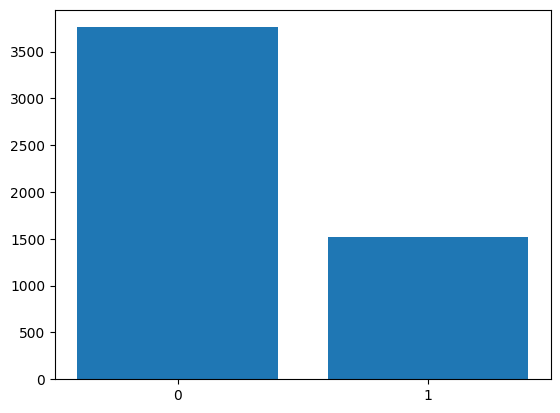

0: 3759
1: 1519


In [4]:
# Ver los datos saber si es balanceado o desbalanceado
count_0 = 0
count_1 = 0

for label in tr_y:
    label = label.strip()
    if label == '0':
        count_0 += 1
    elif label == '1':
        count_1 += 1

plt.bar(['0','1'],[count_0,count_1])
plt.show()

print(f"0: {count_0}")
print(f"1: {count_1}")

In [5]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

corpus_de_palabras = []

for doc in tr_txt:
    corpus_de_palabras += tokenizer.tokenize(doc)
    
fdist = nltk.FreqDist(corpus_de_palabras)



In [6]:
"""
VERSION DEL PROFE
"""


def sort_dist(freq_dist):
    aux = [(freq_dist[key], key) for key in freq_dist.keys()]
    aux.sort(reverse=True)
    return aux

vocabulario = sort_dist(fdist)

vocabulario = vocabulario[:5000] # Shape (5000, 2)


# Es redundante pero asegura un orden en diccionario en Python (No importa por que python se indexa)

dict_indices = {}

contador = 0

for peso, palabra in vocabulario:
    dict_indices[palabra] = contador
    contador += 1
    

def built_bow_tr_profe_version(tuits, Vocabulario, dict_indices):
    
    BOW = np.zeros((len(tuits), len(Vocabulario)), dtype=int)

    contador = 0
    for tr in tuits:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr.lower())) # Tuit Tokenizado
        for palabra in fdist_doc:
            if palabra in dict_indices:
                BOW[contador, dict_indices[palabra]] = fdist_doc[palabra] # FRECUENCIA DE LA PALABRA EN VEZ DE HACERLO BINARIO
        contador += 1

    return BOW


In [7]:
bolsa_de_palabras_tr = built_bow_tr_profe_version(tr_txt, vocabulario, dict_indices)
print(bolsa_de_palabras_tr.shape)

(5278, 5000)


In [8]:
bolsa_de_palabras_tr

array([[0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], shape=(5278, 5000))

# Compute Document Ocurrence Representation


In [9]:


# count * log(T / Nk)
def calcular_peso(freq, Nk_j, T):
    if freq == 0:
        return 0.0
    return freq * np.log(T / max(1, Nk_j)) 



def compute_dor(bow, vocabulario):
    renglones, columnas = bow.shape
    assert columnas == len(vocabulario), "El vocabulario no coincide con columnas en BOW"
    

    Nk = (bow > 0).sum(axis=0) # Tamaño 
    T = renglones

    dor = np.zeros((renglones, columnas), dtype=float)
    
    for i in range(renglones):
        for j in range(columnas):
            dor[i, j] = calcular_peso(bow[i, j], Nk[j], T)
            
    return dor

In [10]:
dor = compute_dor(bolsa_de_palabras_tr, vocabulario)
print(dor.shape)

(5278, 5000)


In [11]:
dor

array([[0.        , 1.61486246, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.80743123, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.80743123, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.84894225, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.92447113, 0.80743123, 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(5278, 5000))

In [12]:
def compute_dor_profe(TR):
    DTR = np.zeros((TR.shape[1], TR.shape[0]), dtype=float)

    tam_v = TR.shape[1] # Tamaño del vocabulario TOTAL
    
    for i,doc in enumerate(TR):
        non_zero_positions = np.nonzero(doc)[0] # Esto me dice las dimensiones que no son cero
        tamaño_vocabulario = len(non_zero_positions)
        for termino in non_zero_positions:
            DTR[termino, i] = doc[termino] * np.log(tam_v / tamaño_vocabulario)
    return DTR

In [13]:
DRT = compute_dor_profe(bolsa_de_palabras_tr)



# Normalización

In [14]:

DOR_normalizado = preprocessing.normalize(DRT, norm='l2')

print(DOR_normalizado.shape)

(5000, 5278)


In [15]:
from sklearn.feature_selection import SelectKBest, chi2

feature_selector = SelectKBest(chi2, k=1000)

# Aprende a como hacer selección de las palabras de manera muy interesante en automatico les da la relevancia
feature_selector.fit(bolsa_de_palabras_tr, tr_y)



,score_func,<function chi2 at 0x11cb4d440>
,k,1000


In [16]:
best = feature_selector.get_support(indices=True)

In [17]:
best

array([   0,    1,    2,    4,    5,    6,    7,   10,   11,   12,   13,
         17,   18,   19,   20,   22,   24,   25,   28,   30,   32,   36,
         37,   38,   39,   41,   43,   44,   48,   50,   53,   54,   56,
         57,   58,   59,   61,   63,   64,   65,   66,   67,   69,   70,
         71,   75,   78,   79,   86,   88,   89,   92,   93,   94,   97,
        100,  102,  103,  104,  105,  106,  107,  108,  111,  114,  115,
        116,  117,  119,  120,  122,  123,  124,  128,  129,  131,  133,
        134,  136,  143,  147,  148,  150,  151,  153,  154,  163,  166,
        170,  177,  178,  179,  182,  183,  184,  187,  188,  189,  191,
        196,  198,  200,  209,  211,  217,  221,  222,  225,  230,  231,
        233,  236,  237,  240,  243,  245,  246,  248,  249,  250,  252,
        253,  257,  258,  260,  262,  263,  264,  265,  266,  271,  273,
        279,  281,  284,  285,  289,  291,  294,  295,  298,  299,  301,
        302,  304,  306,  307,  308,  309,  310,  3

In [18]:
dict_indices_invertido = {valor: key for key, valor in dict_indices.items()}
dict_indices_invertido

{0: ',',
 1: 'de',
 2: 'que',
 3: '.',
 4: 'la',
 5: 'a',
 6: 'y',
 7: '!',
 8: 'no',
 9: '@USUARIO',
 10: 'me',
 11: 'el',
 12: 'en',
 13: 'se',
 14: 'es',
 15: 'con',
 16: '?',
 17: 'verga',
 18: 'los',
 19: 'madre',
 20: 'por',
 21: 'las',
 22: '"',
 23: 'un',
 24: 'te',
 25: 'mi',
 26: 'lo',
 27: 'putas',
 28: 'una',
 29: '...',
 30: 'putos',
 31: 'para',
 32: '😂',
 33: 'si',
 34: 'ya',
 35: 'como',
 36: 'su',
 37: 'pero',
 38: 'tu',
 39: 'loca',
 40: 'le',
 41: 'más',
 42: 'No',
 43: 'del',
 44: 'gorda',
 45: 'al',
 46: 'bien',
 47: 'A',
 48: '¿',
 49: 'Y',
 50: 'son',
 51: 'Me',
 52: 'o',
 53: 'feas',
 54: 'cuando',
 55: 'Que',
 56: ':',
 57: 'yo',
 58: 'les',
 59: 'porque',
 60: 'ni',
 61: 'está',
 62: 'ser',
 63: 'estoy',
 64: 'sus',
 65: 'todos',
 66: 'esta',
 67: 'puta',
 68: 'Ya',
 69: 'todo',
 70: 'pinche',
 71: 'puto',
 72: 'tan',
 73: 'Si',
 74: 'La',
 75: 'qué',
 76: '…',
 77: 'eso',
 78: 'muy',
 79: 'soy',
 80: 'hasta',
 81: 'así',
 82: '¡',
 83: '<URL>',
 84: 'mamar',


In [19]:
t_words = [dict_indices_invertido[index] for index in best]

In [20]:
# dict_indices {"palabra": "dimension_en_bow",...}
target_matrix = np.array([DOR_normalizado[dict_indices[word]] for word in t_words])

In [21]:
target_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.02700498,
        0.01383511],
       [0.02718223, 0.        , 0.01543368, ..., 0.01631947, 0.        ,
        0.01478211],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(1000, 5278))

In [22]:
target_matrix.shape

(1000, 5278)

In [23]:
DOR_normalizado.shape

(5000, 5278)

# Reducción de Dimensionalidad

In [24]:
from sklearn.manifold import TSNE


reduce_matrix = TSNE(n_components=2).fit_transform(target_matrix)


In [25]:
reduce_matrix

array([[  1.7752128 ,  -4.4757233 ],
       [  1.5154654 ,  -3.312561  ],
       [  0.66699994,  -4.291525  ],
       ...,
       [ 40.40431   ,   4.84924   ],
       [  9.566699  ,  20.236397  ],
       [  9.040356  , -10.720434  ]], shape=(1000, 2), dtype=float32)

In [26]:
max_x , max_y = np.max(reduce_matrix, axis=0)
min_x , min_y = np.min(reduce_matrix, axis=0)


print(f"max_x: {max_x}, max_y: {max_y}")
print(f"min_x: {min_x}, min_y: {min_y}")

max_x: 48.461910247802734, max_y: 45.44157409667969
min_x: -50.798213958740234, min_y: -49.45492172241211


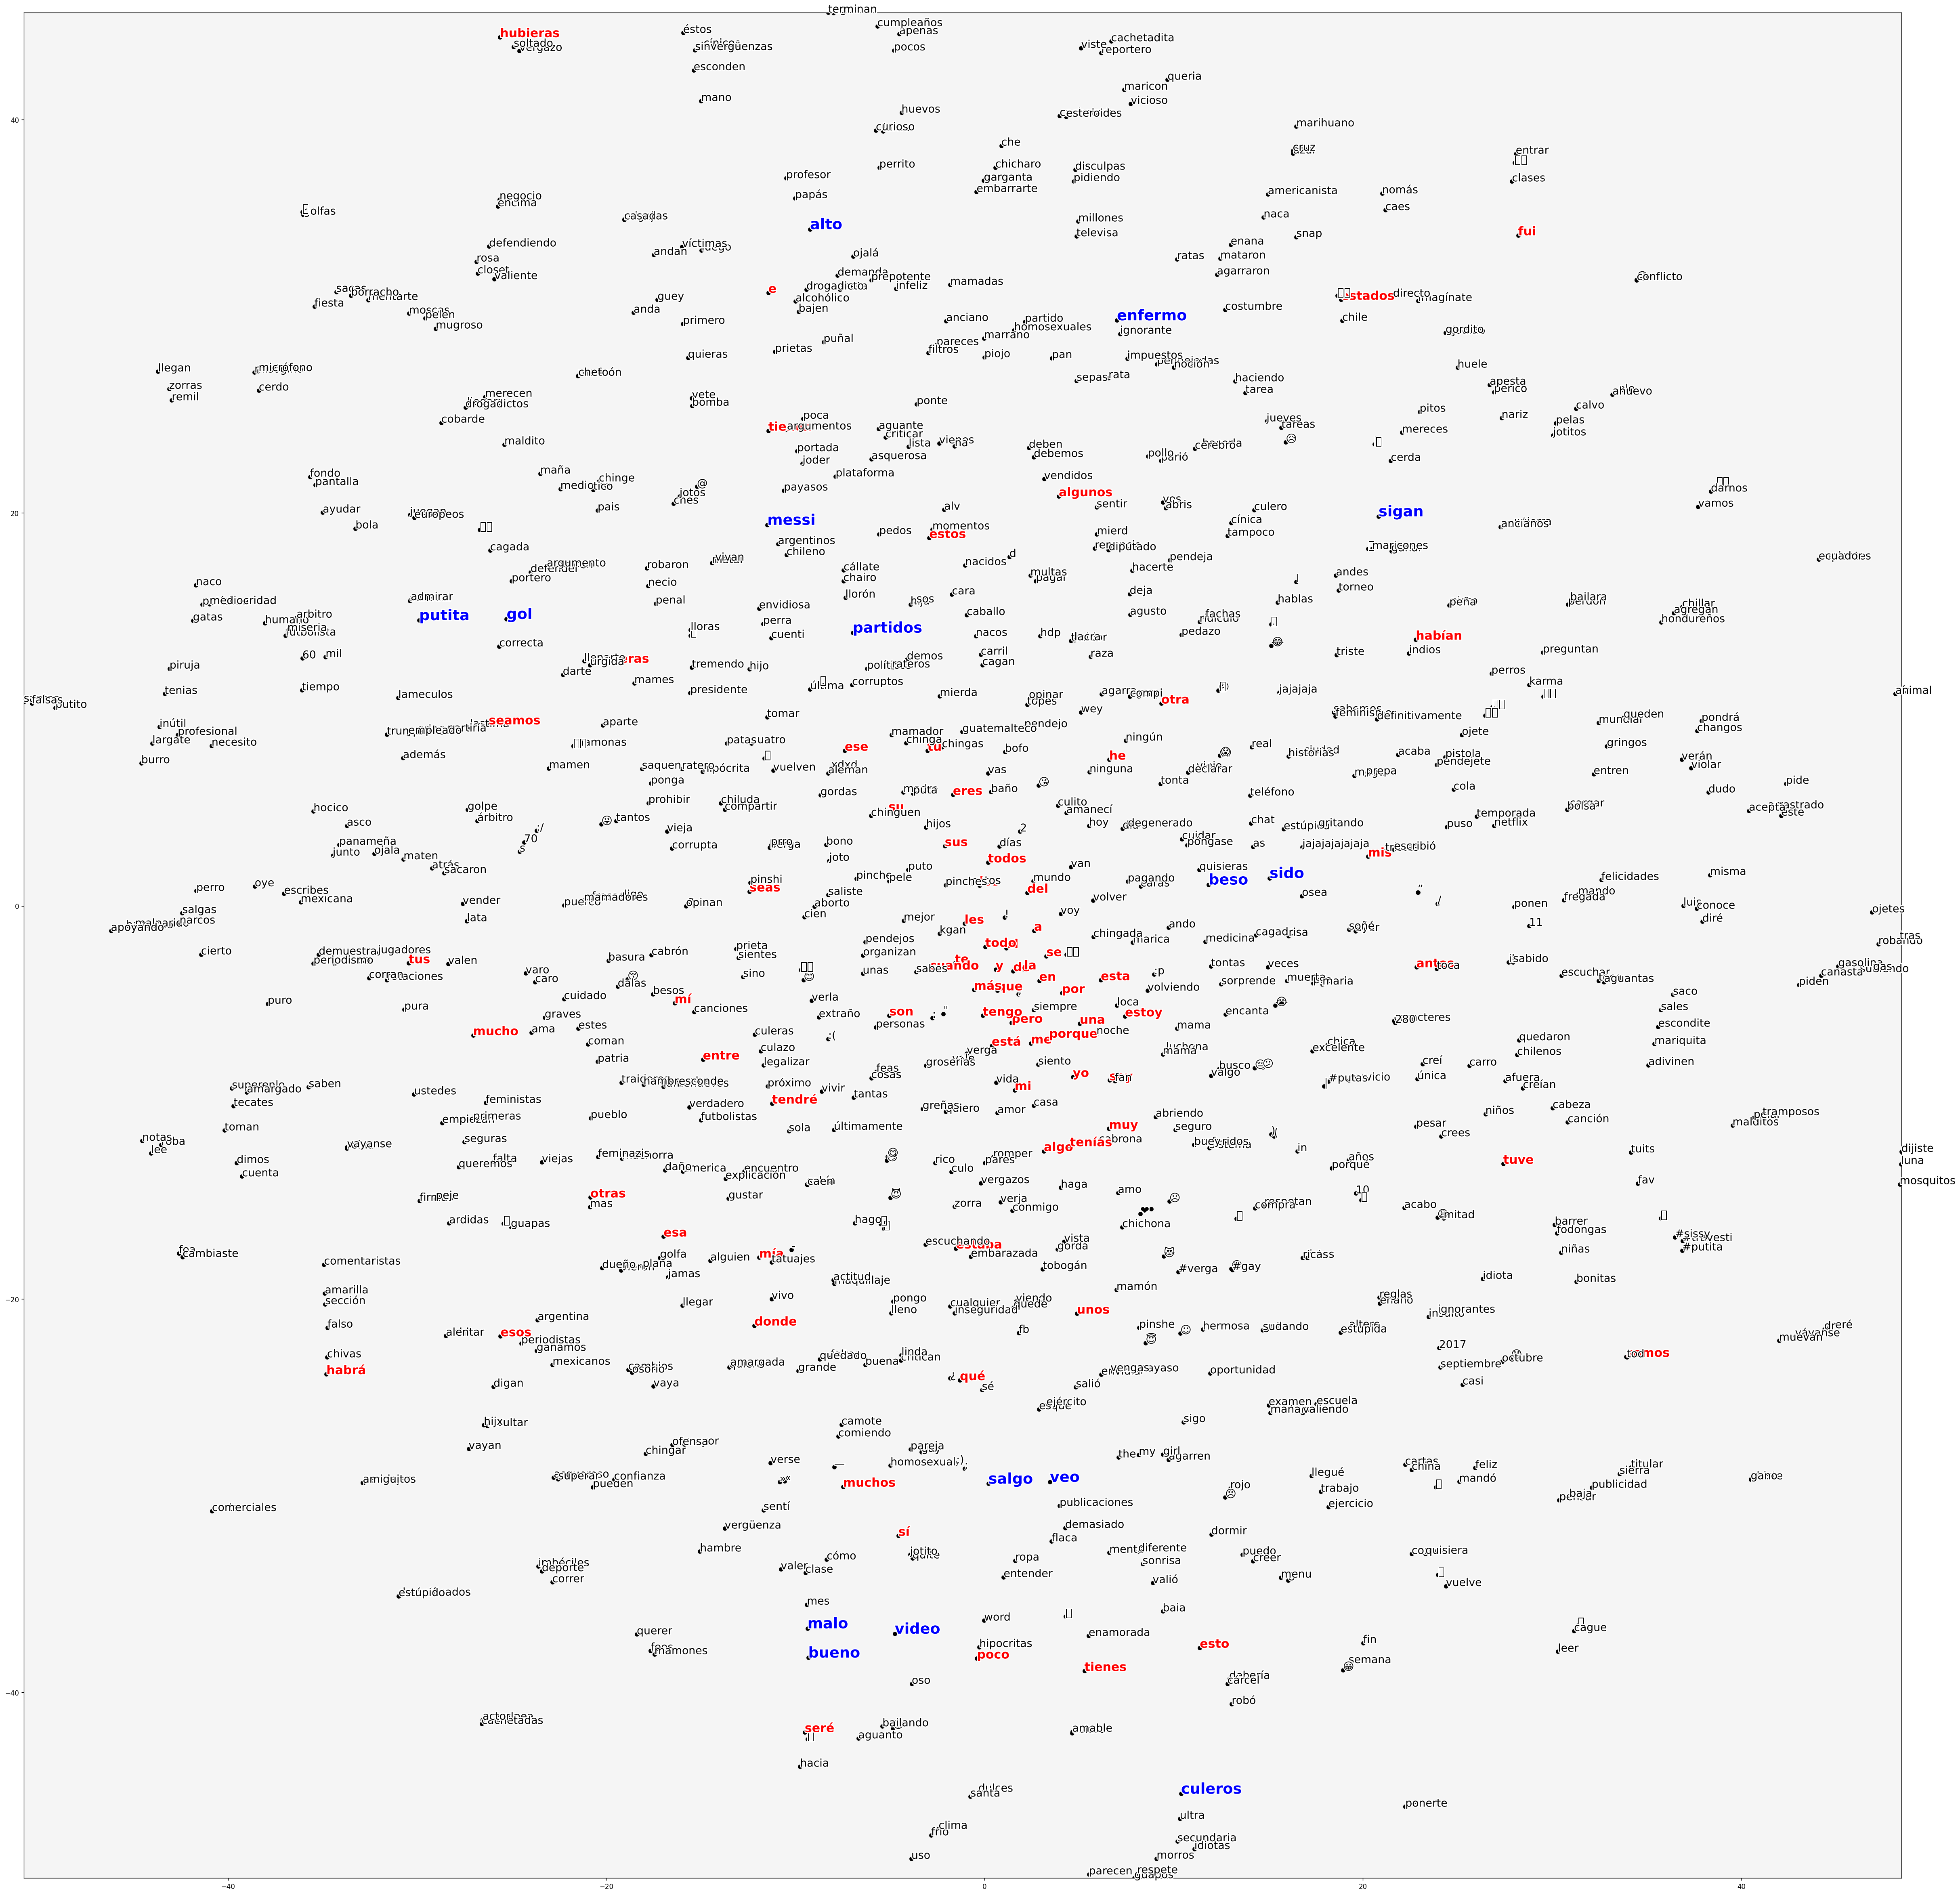

In [30]:
from matplotlib import patheffects

x, y = reduce_matrix[:, 0], reduce_matrix[:, 1]

plt.figure(figsize=(50, 50), dpi=120)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.scatter(x, y, s=30, color='black')






sw = stopwords.words('spanish')


for i, word in enumerate(t_words):
    if word in sw:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=18, 
            color='red', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    elif word in ['messi', 'partidos', 'beso', 'enfermo', 'sigan', 'corrupto', 'putas', 'malo', 'bueno', 'sido',
                   'alto', 'gol', 'putita', 'veo', 'salgo', 'abaco', 'video', 'culeros']:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=22, 
            color='blue', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    else:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=16, 
            color='black',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )

plt.gca().set_facecolor('whitesmoke')
plt.show()
